In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import v2
import sys
sys.path.append('../')
from utils.helper import fn_plot_torch_hist

In [2]:
###----------------
# Global Variables
###----------------


TEST_SIZE = 0.2
RANDOM_STATE = 24
np.random.RandomState(seed=RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
# to control if it needs to be trained
trainModel =True


BATCH_SIZE = 16
TRAIN_SIZE = 2*92*BATCH_SIZE
EPOCHS = 100
LR_FACTOR = 0.1
LR_PATIENCE = 10
ALPHA = 0.001
IMG_WIDTH = 186
IMG_HEIGHT = 186


# set location of input files and output files
inpDir = '../input'
outDir = '../output'
modelDir = '../models'
subDir = 'flower_photos'
altName = 'torch_flower_base'

# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

## Load the data


In [3]:
data_dir = os.path.join(inpDir, subDir)

In [4]:
modelPath = os.path.join(modelDir, subDir, f'{altName}.pkl')

In [5]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [6]:
# checking for GPU availability
display(torch.cuda.is_available())
display(torch.version.cuda)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
display(device)

False

None

'cpu'

In [7]:
# to accept and plot the images in data_dir
def fn_imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()  # just create a new subplot if there is no subplot mentioned in the params
    
    image = image.numpy().transpose((1,2,0))

    if normalize:
        mean = np.array([0.485, 0.465, 0.406]) # hardcoded values in documentation
        std = np.array([0.229, 0.224, 0.406]) # also hardcoded values
        image = std*image + mean 
        image = np.clip(image ,0, 1)
    
    ax.imshow(image)

    # improves display
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_aspect('equal')
    
    if title is not None:
        ax.set_title(title)
        
    return ax


### Transforms to be applied on the images
#### Separately for train and test


In [8]:
train_transform = v2.Compose([v2.Resize(IMG_HEIGHT), 
                              v2.CenterCrop(IMG_HEIGHT), 
                              v2.ToImage(),
                              v2.ToDtype(torch.float32, scale=True), 
                              v2.Normalize(mean = [0.485, 0.465, 0.406],
                                            std = [0.229, 0.224, 0.406])])
train_transform

Compose(
      Resize(size=[186], interpolation=InterpolationMode.BILINEAR, antialias=True)
      CenterCrop(size=(186, 186))
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.465, 0.406], std=[0.229, 0.224, 0.406], inplace=False)
)

In [9]:
test_transform = v2.Compose([v2.Resize(IMG_HEIGHT), 
                              v2.CenterCrop(IMG_HEIGHT), 
                              v2.ToImage(),
                              v2.ToDtype(torch.float32, scale=True), 
                              v2.Normalize(mean = [0.485, 0.465, 0.406],
                                            std = [0.229, 0.224, 0.406])])
test_transform

Compose(
      Resize(size=[186], interpolation=InterpolationMode.BILINEAR, antialias=True)
      CenterCrop(size=(186, 186))
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.465, 0.406], std=[0.229, 0.224, 0.406], inplace=False)
)

### Load the images

In [10]:
# function for loading the images
def create_dataset(data_dir, train_transform, test_transform):
    train_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(data_dir, transform=test_transform)
    train_dataset_size = len(train_dataset)
    indices = torch.randperm(train_dataset_size).tolist()
    dataset_train  = torch.utils.data.Subset(train_dataset, indices[:TRAIN_SIZE])
    dataset_test = torch.utils.data.Subset(test_dataset, indices[TRAIN_SIZE:])
    return dataset_train, dataset_test

In [11]:
# actually loading the training and test images
train_ds, test_ds = create_dataset(data_dir, train_transform, test_transform)
len(train_ds) # train set size

2944

In [12]:
len(test_ds) # test set size

726

In [13]:
class_names = {count: class_name for count, class_name in enumerate(train_ds.dataset.classes)}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

### Using DataLoader to load data

In [14]:
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
images, labels = next(iter(train_dataloader))
images.shape, labels.shape # batch size, channel, height, width

(torch.Size([16, 3, 186, 186]), torch.Size([16]))

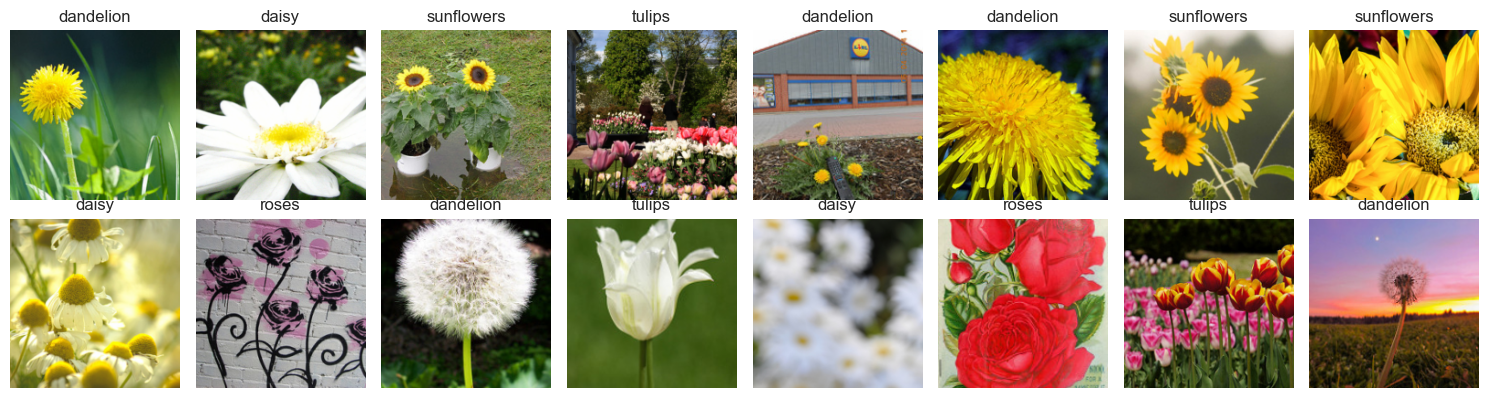

In [16]:
fig = plt.figure()
for i in range(BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE//8, 8,  (i+1), xticks=[], yticks=[])
    fn_imshow(images[i], ax=ax, normalize=True)
    ax.set_title(class_names[labels[i].item()])
plt.tight_layout()
    

In [17]:
images, labels = next(iter(test_dataloader))
images.shape, labels.shape # batch size, channel, height, width

(torch.Size([16, 3, 186, 186]), torch.Size([16]))

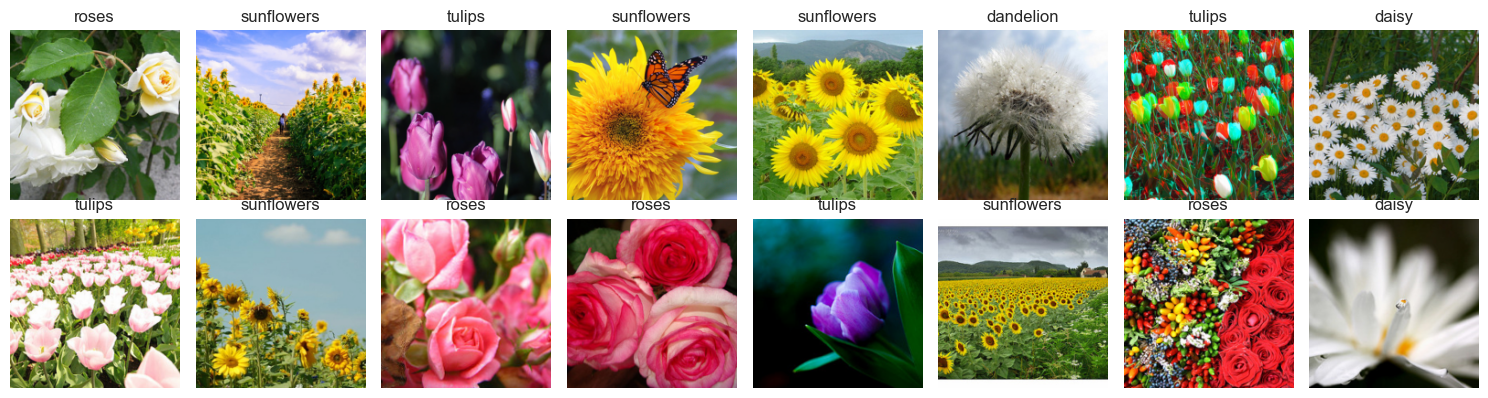

In [18]:
fig = plt.figure()
for i in range(BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE//8, 8,  (i+1), xticks=[], yticks=[])
    fn_imshow(images[i], ax=ax, normalize=True)
    ax.set_title(class_names[labels[i].item()])
plt.tight_layout()

In [19]:
class Model(nn.Module):
    def __init__(self, numChannels, classes):
        super(Model, self).__init__()

        dor1 = 0.1
        # set 1
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=64, kernel_size=(3,3))  # 184, 184, 64
        self.actv1 = nn.LeakyReLU()
        # self.do1 = nn.Dropout(dor1)
        # self.bn1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(4,4),
                                     stride=(4,4))  # 46, 46, 64
        

        # set 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3))  # 44, 44, 128
        self.actv2 = nn.LeakyReLU()
        # self.do2 = nn.Dropout(dor2)
        # self.bn2 = nn.BatchNorm2d(128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2),
                                     stride=(2,2))  # 22, 22, 128
        


        # set 3
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3))  # 20, 20, 256 
        self.actv3 = nn.LeakyReLU()
        # self.do3 = nn.Dropout(dor3)
        # self.bn3 = nn.BatchNorm2d(256
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2),
                                     stride=(2,2))  # 10, 10, 256
        

        # set 4
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3))  # 8, 8, 512
        self.actv4 = nn.LeakyReLU()
        # self.do4 = nn.Dropout(dor4)
        # self.bn4 = nn.BatchNorm2d(512)
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2,2),
                                     stride=(2,2))  # 4, 4, 512
        


        ##############
        #### HEAD ####
        ##############
        self.fcl1 = nn.Linear(in_features=4*4*512, out_features=1024)
        self.actv5 = nn.LeakyReLU()
        # self.do5 = nn.Dropout(dor5)
        # self.bn5 = nn.BatchNorm2d(1024)
        self.fcl2 = nn.Linear(in_features=1024, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
    


    def forward(self, x):
        # set1
        x = self.conv1(x)
        x = self.actv1(x)
        # x = self.do1(x)
        # x = self.bn1(x)
        x = self.maxpool1(x)
        
        # set2
        x = self.conv2(x)
        x = self.actv2(x)
        # x = self.do2(x)
        # x = self.bn2(x)
        x = self.maxpool2(x)
        
        # set3
        x = self.conv3(x)
        x = self.actv3(x)
        # x = self.do3(x)
        # x = self.bn3(x)
        x = self.maxpool3(x)
        
        # set4
        x = self.conv4(x)
        x = self.actv4(x)
        # x = self.do4(x)
        # x = self.bn4(x)
        x = self.maxpool4(x)
        
        x = torch.flatten(x, 1)

        # fully connected layers
        # head
        x = self.fcl1(x)
        x = self.actv5(x)
        # x = self.do5(x)
        # x = self.bn5(x)
        x = self.fcl2(x)
        x = self.logSoftmax(x)
        return x



model = Model(numChannels=3, classes=10) # calling the model
print(model)

Model(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (actv1): LeakyReLU(negative_slope=0.01)
  (maxpool1): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (actv2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (actv3): LeakyReLU(negative_slope=0.01)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (actv4): LeakyReLU(negative_slope=0.01)
  (maxpool4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fcl1): Linear(in_features=8192, out_features=1024, bias=True)
  (actv5): LeakyReLU(negative_slope=0.01)
  (fcl2): Linear(in_features=1024, out_features=10, bias=True)
  (logSoftm

In [20]:
# modelPath = os.path.join(modelDir, subDir, f'torch_flowers{torch.version.cuda}.pkl')
# modelPath
_ = summary(model, (3, IMG_HEIGHT, IMG_WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 184, 184]           1,792
         LeakyReLU-2         [-1, 64, 184, 184]               0
         MaxPool2d-3           [-1, 64, 46, 46]               0
            Conv2d-4          [-1, 128, 44, 44]          73,856
         LeakyReLU-5          [-1, 128, 44, 44]               0
         MaxPool2d-6          [-1, 128, 22, 22]               0
            Conv2d-7          [-1, 256, 20, 20]         295,168
         LeakyReLU-8          [-1, 256, 20, 20]               0
         MaxPool2d-9          [-1, 256, 10, 10]               0
           Conv2d-10            [-1, 512, 8, 8]       1,180,160
        LeakyReLU-11            [-1, 512, 8, 8]               0
        MaxPool2d-12            [-1, 512, 4, 4]               0
           Linear-13                 [-1, 1024]       8,389,632
        LeakyReLU-14                 [-

In [21]:
# loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='min',
                                                       factor=LR_FACTOR, 
                                                       patience=LR_PATIENCE, 
                                                       verbose=True,    
                                                       min_lr=1e-5)
# always need to write 
# some lists to collect progress
loss = []
tloss = []
n_epoch = []
acc = []
tacc=[]

# loop for definedd epochs
for epoch in range(EPOCHS):
    model.train() # set model in training mode 
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0
   
    for batch_idx, (train_X, train_y) in enumerate(train_dataloader):
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        predict_proba = model(train_X) # make predict
        batch_loss = loss_fn(predict_proba, train_y) # calculate loss
        epoch_loss += (batch_loss - epoch_loss) / (batch_idx+1) # calculate running mean -> batch loss for each batch -> then calculate avg loss for epoch
        #curr_loss = loss_fn(predict_proba, train_y)
        # Backpropagation
        optimizer.zero_grad() # Gradient set to Zero
        batch_loss.backward() # calculate loss in backpropagation
        optimizer.step() # move with the steps given by optimizer
        y_pred = predict_proba.argmax(dim=1).cpu().numpy()
        batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
        epoch_acc += (batch_acc - epoch_acc)/(batch_idx+1) #accuracy for each batch -> then calculate avg accuracy for epoch
        
    loss.append(epoch_loss.data.item())
    acc.append(epoch_acc)

    model.eval()

    for batch_idx, (test_X, test_y) in enumerate(test_dataloader):
        test_X, test_y = test_X.to(device), test_y.to(device)
        test_proba = model(test_X)
        batch_loss = loss_fn(test_proba, test_y)
        tepoch_loss += (batch_loss - tepoch_loss)/ (batch_idx + 1)

        y_pred =test_proba.argmax(dim=1).cpu().numpy()
        batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
        tepoch_acc += (batch_acc - tepoch_acc)/(batch_idx+1) #accuracy for each batch -> then calculate avg accuracy for epoch
    
    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.data.item())
    n_epoch.append(epoch)
    # loss.append(curr_loss.data.item())
    # y_pred = torch.argmax(predict_proba, dim=1).cpu().numpy()
    # curr_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
    # acc.append(curr_acc)

    # model.eval()# set your model in eval mode
    # test_proba = model(test_X) # make prediction
    # test_loss = loss_fn(test_proba, test_y) # calculate loss
    # tloss.append(test_loss.data.item()) # append for plotting
    
    # y_pred = torch.argmax(test_proba, dim=1).cpu().numpy()
    # test_acc = accuracy_score(test_y.cpu().numpy(),y_pred)
    # tacc.append(test_acc)
    # n_epoch.append(epoch)

    #LR Reduction step
    scheduler.step(tepoch_loss)
    if epoch % 10 == 0:
        print(f'Epoch:{epoch:>5d} | Loss: {epoch_loss:0.5f}/{tepoch_loss:0.5f}| Accuracy: {epoch_acc:0.5f}/{tepoch_acc:0.5f}')
        print(f'Acc: {epoch_acc: .5f}/{tepoch_acc: .5f}')
        print(f'LR: {scheduler.get_last_lr()[0]: .5f}')
    

c:\Users\DAI.STUDENTSDC\.conda\envs\pythonProject\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch:    0 | Loss: 1.30362/1.25812| Accuracy: 0.45075/0.44882
Acc:  0.45075/ 0.44882
LR:  0.00100
Epoch:   10 | Loss: 0.16703/1.68760| Accuracy: 0.94735/0.61639
Acc:  0.94735/ 0.61639
LR:  0.00100
Epoch:   20 | Loss: 0.00135/2.20667| Accuracy: 1.00000/0.70969
Acc:  1.00000/ 0.70969
LR:  0.00010
Epoch:   30 | Loss: 0.00036/2.48952| Accuracy: 1.00000/0.71105
Acc:  1.00000/ 0.71105
LR:  0.00001
Epoch:   40 | Loss: 0.00026/2.57506| Accuracy: 1.00000/0.70833
Acc:  1.00000/ 0.70833
LR:  0.00001
Epoch:   50 | Loss: 0.00016/2.69881| Accuracy: 1.00000/0.70562
Acc:  1.00000/ 0.70562
LR:  0.00001
Epoch:   60 | Loss: 0.00008/2.86162| Accuracy: 1.00000/0.70562
Acc:  1.00000/ 0.70562
LR:  0.00001
Epoch:   70 | Loss: 0.00003/3.06269| Accuracy: 1.00000/0.70562
Acc:  1.00000/ 0.70562
LR:  0.00001
Epoch:   80 | Loss: 0.00001/3.28585| Accuracy: 1.00000/0.70426
Acc:  1.00000/ 0.70426
LR:  0.00001
Epoch:   90 | Loss: 0.00000/3.51046| Accuracy: 1.00000/0.70290
Acc:  1.00000/ 0.70290
LR:  0.00001


In [22]:
tepoch_loss

tensor(3.7085, grad_fn=<AddBackward0>)